# 1. Introduction

This dataset, named hate_speech_offensive, is a meticulously curated collection of annotated tweets with the specific purpose of detecting hate speech and offensive language. The dataset primarily consists of English tweets and is designed to train machine learning models or algorithms in the task of hate speech detection.<br>
The dataset includes several columns that provide valuable information for understanding each tweet's classification. The column count represents the total number of annotations provided for each tweet, whereas hate_speech_count signifies how many annotations classified a particular tweet as hate speech. On the other hand, offensive_language_count indicates the number of annotations categorizing a tweet as containing offensive language. Additionally, neither_count denotes how many annotations identified a tweet as neither hate speech nor offensive language.

Let's delve into the key columns:

| Column name              | Type   | Description                                                                                  |
|--------------------------|--------|----------------------------------------------------------------------------------------------|
| count                    | int    | The total number of annotations for each tweet.                                              |
| hate_speech_count        | int    | The number of annotations classifying a tweet as hate speech.                                |
| offensive_language_count | int    | The number of annotations classifying a tweet as offensive language.                         |
| neither_count            | int    | The number of annotations classifying a tweet as neither hate speech nor offensive language. |
| class                    | int    | Tweet type, 0 for hate, 1 for offensive and 2 for neutral.                                   |
| tweet                    | object | Annotated tweet                                                                              |

# 2. Import Dataset and packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# Preprocess:
from sklearn.model_selection import train_test_split

# Models:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model selection:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Metrics:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Warnings:
import warnings
warnings.filterwarnings("ignore")

# Time:
import tqdm

In [3]:
# Load dataset:
df = pd.read_csv("twitter_comments.csv")

Credit to https://huggingface.co/datasets/hate_speech_offensive.

In [4]:
df_preprocess = df.copy()

# 3. Data Preparation

In this section we're gonna prepare and organize the data. This involves cleaning and pre-processing the raw data, and structuring it in a way that is conducive to effective analysis and model training.

## 3.1. Exploratory Data Analysis

Before diving into the technical aspects of the project, it's crucial to gain a comprehensive understanding of the data. Exploratory Data Analysis (EDA) involves visualizing and summarizing key characteristics of our dataset. This section helps us identify patterns, outliers, and potential challenges, providing valuable insights that inform subsequent stages of your project.

In [5]:
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     24783 non-null  int64 
 1   hate_speech_count         24783 non-null  int64 
 2   offensive_language_count  24783 non-null  int64 
 3   neither_count             24783 non-null  int64 
 4   class                     24783 non-null  int64 
 5   tweet                     24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [6]:
df_preprocess.head(3)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...


In [7]:
language = df_preprocess["class"].value_counts().to_frame().T
language.columns = ["offensive", "neutral", "hate"]
language

,offensive,neutral,hate
count,19190,4163,1430


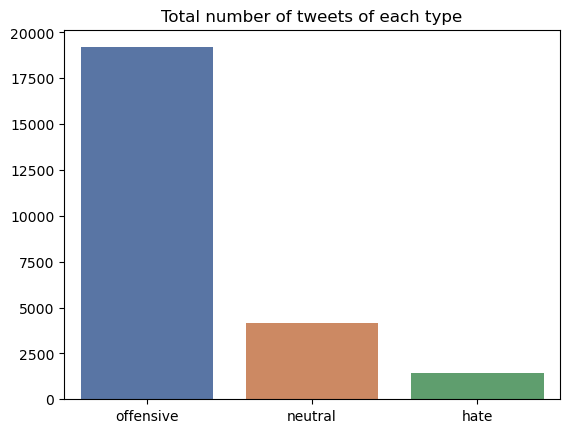

In [8]:
sns.barplot(language, palette= "deep")
plt.title("Total number of tweets of each type")
plt.show()

In [9]:
language_count = df_preprocess[["hate_speech_count", "offensive_language_count", "neither_count"]].sum(axis=0).sort_values(ascending= False).to_frame().T
language.columns = ["offensive_language", "neutral", "hate_speech"]
language_count.index = ["count"]
language_count

,offensive_language_count,neither_count,hate_speech_count
count,59819,13612,6952


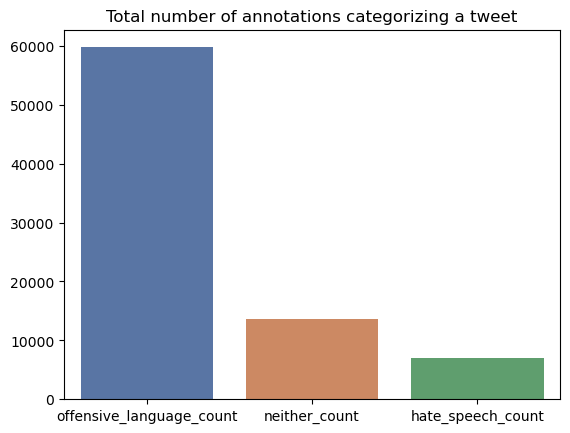

In [10]:
sns.barplot(language_count, palette= "deep")
plt.title("Total number of annotations categorizing a tweet")
plt.show()

## 3.2. Data Processing

Data processing is a critical step to ensure that our data is in a suitable format for training and evaluation. This includes tasks such as tokenization, stemming, and handling missing values. The goal is to transform the raw data into a format that is compatible with the chosen language detection model.

- ### Checking duplicates and missing values

In [11]:
df_preprocess.isna().sum()

count                       0
hate_speech_count           0
offensive_language_count    0
neither_count               0
class                       0
tweet                       0
dtype: int64

In [12]:
df_preprocess[df_preprocess.duplicated()]

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet


**There are no missing values, and there are neither duplicates.**

- ### Column Selection

In [13]:
df_preprocess = df_preprocess[["class", "tweet"]]
df_preprocess.head(3)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...


- ### Text processing

Stopwords used for cleaning:

In [14]:
stopwords = nltk.corpus.stopwords.words("english")

    -Functions for cleaning:

In [15]:
def delete_sign(text):
    '''
    Function made to clean signs from the text.
    '''
    
    clean_text= ""
    for char in text:
        if char.isalnum() or char.isspace():
            clean_text += char       
    return clean_text

In [16]:
# Text cleaning function

def text_cleaning(text, stemm = False):
    
    # Quito URL's
    clean_text = re.sub(r'http[s]?://\S+', '', text)
    
    # Quito usuarios de twitter
    clean_text = re.sub(r'@([A-Za-z0-9_]+)', "", clean_text)
    
    # Quito emojis
    clean_text = re.sub(r'&#[0-9]+;', '', clean_text)
    
    # Quito signos
    clean_text = delete_sign(clean_text)
    
    # Quito RT, dobles y triples espacios y espacios a comienzo y final de frase
    clean_text = clean_text.replace("RT", "").strip().replace("   ", " ").replace("  ", " ")
    
    # Quito saltos de línea
    clean_text = re.sub(r'\s+', ' ', clean_text)
    
    # Paso todo a minusculas:
    clean_text = clean_text.lower()
    
    # Quito stopwords:
    tokens = nltk.word_tokenize(text = clean_text, language = "english")
    
    clean_tokens = []
    stemmer = PorterStemmer()
    for token in tokens: 
        if token not in stopwords: 
            if len(token) > 2:
                if stemm:
                    token = stemmer.stem(token)
                    clean_tokens.append(token)
                else:
                    clean_tokens.append(token)

    clean_text = " ".join(clean_tokens)
    
    return clean_text

#### Cleaning steps:
    - Remove URLs
    - Remove Twitter users
    - Remove emojis
    - Remove punctuation
    - Remove "RT", double and triple spaces, and spaces at the beginning and end of sentences
    - Remove line breaks
    - Convert everything to lowercase
    - Remove stopwords
    - Stemming    

In [17]:
df_preprocess["clean_tweet"] = df_preprocess["tweet"].apply(text_cleaning, stemm = True)

In [18]:
df_preprocess.head(3)

,class,tweet,clean_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain clean hous amp man alw...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat coldtyga dwn bad cuffin dat hoe 1st place
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit


####  Five most frequently used words in each class:

In [19]:
classes = df_preprocess["class"].unique()
most_common_word = {}
for clss in classes:
    mask = (df_preprocess["class"] == clss)
    
    word_count = Counter()
    for text in df_preprocess[mask]["clean_tweet"].values:
        for word in text.split():
            word_count[word] += 1
        
    common_words = word_count.most_common(5)
    most_common_word[clss] = [word[0] for word in common_words]
    
df_most_common_word = pd.DataFrame(most_common_word)
df_most_common_word.columns = ["neutral" if col == 2 else "offensive" if col == 1 else "hate" for col in df_most_common_word.columns]
df_most_common_word

,neutral,offensive,hate
0,trash,bitch,bitch
1,bird,hoe,faggot
2,like,like,fuck
3,yanke,pussi,nigga
4,charli,fuck,like


##### *The text is clean, next step will be text transformation.*

- ### Text transformation:

    - Vectorization:

In [20]:
# Inicializamos un objeto CountVecrtorizer()
count_vectorizer = CountVectorizer(max_features = 3000) # ese parametro se queda con el top 1k palabras más utilizadas

# Entrenamos el modelo y transformamos los datos:
x = count_vectorizer.fit_transform(df_preprocess["clean_tweet"])

    - Term Frequency-Inverse Document Frequency (TF-IDF) Transformation:

In [21]:
# Inicializamos un objeto Tfidf. Ajustará los pesos de las palabras que aparecen en los tweets
tfidf = TfidfTransformer()

# Entrenamos el Tfidf y transformamos:
X_processed = tfidf.fit_transform(x)

- ### Variable selection:

In [22]:
X = X_processed.copy()
y = df_preprocess["class"]

- ### Train/Test Split:

In [23]:
X, X_test_real, y, y_test_real = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify= y)

In [25]:
print(f"X_train: {X.shape}, y_train: {y.shape}")
print(f"X_test: {X_test_real.shape},  y_test: {y_test_real.shape}")

X_train: (19826, 3000), y_train: (19826,)
X_test: (4957, 3000),  y_test: (4957,)


# 4. Training Model

This section focuses on the core of our language detection project — building and training the model that will make predictions based on the input data.

## 4.1. Model Selection

In this subsection we'll explore various models and select the one that best aligns with our project goals and dataset characteristics. Consider factors such as model complexity, computational requirements, and performance metrics.

### 4.1.1. Multinomial Naive Bayes(MNB) Model

Well-suited for text classification tasks, especially when dealing with word counts or term frequencies. It assumes that the features are conditionally independent, given the class.

In [23]:
MNB_model = MultinomialNB()

### 4.1.2. Support Vector Machines(SVM) Model

SVMs are powerful classifiers that work well in high-dimensional spaces. They can be effective for text classification tasks, and various kernel functions can be used to capture complex relationships.

In [24]:
SVM_model = SVC()

### 4.1.3. Logistic Regression(LR) Model

Logistic Regression is a simple yet effective linear model for multiclass classification. It works well for text data.

In [25]:
LR_model = LogisticRegression()

### 4.1.4.Random Forest Classifier(RFC) Model

Random Forest is an ensemble learning method that combines multiple decision trees to improve overall performance. It is robust, handles non-linear relationships well, and can be effective for text classification.

In [26]:
RFC_model = RandomForestClassifier()

In [27]:
############################################################

**Lista de modelos para entrenar:**

In [28]:
models = [MNB_model, SVM_model, LR_model, RFC_model]

In [29]:
############################################################

## 4.2. Cross Validation

To assess the generalization performance of our model, we'll employ cross-validation techniques. This involves splitting our dataset into multiple subsets, training the model on different combinations of these subsets, and evaluating its performance. Cross-validation helps ensure that our model is robust and not overfitting to the training data.

### 4.2.1. Hold-Out

In [45]:
%%time

model_acc_holdout = []

for model in models:

    accuracy_holdout, precision_holdout, recall_holdout, f1_holdout = [], [], [], []
    for i in tqdm.tqdm(range(50)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy_holdout.append(accuracy_score(y_test, y_pred))
        precision_holdout.append(precision_score(y_test, y_pred, average = "macro"))
        recall_holdout.append(recall_score(y_test, y_pred, average = "macro"))
        f1_holdout.append(f1_score(y_test, y_pred, average = "macro"))
    
    model_acc_holdout.append([str(model).split("(")[0],
                              np.array(accuracy_holdout).mean(),
                              np.array(precision_holdout).mean(),
                              np.array(recall_holdout).mean(),
                              np.array(f1_holdout).mean()
                             ])

df_acc_holdout = pd.DataFrame(model_acc_holdout, columns= ["model", "mean_accuracy", "mean_precision", "mean_recall", "mean_f1"])
df_acc_holdout

100%|██████████| 50/50 [14:13<00:00, 17.08s/it]

CPU times: total: 21min 51s
Wall time: 22min 2s


,model,mean_accuracy,mean_precision,mean_recall,mean_f1
0,MultinomialNB,0.835107,0.838682,0.464279,0.489041
1,SVC,0.898562,0.782167,0.650470,0.666663
2,LogisticRegression,0.895296,0.786671,0.656777,0.685515
3,RandomForestClassifier,0.902150,0.778186,0.680123,0.694505


### 4.2.2. k-Fold Cross Validation

In [46]:
kfold = KFold(n_splits = 5)
model_acc_kfold = []

for model in models:
    y_pred = []
    for train_index, test_index in tqdm.tqdm(kfold.split(X)): 

        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]

        model.fit(X_train, y_train)
        y_pred_1 = model.predict(X_test)
        y_pred.extend(y_pred_1)

    model_acc_kfold.append([str(model).split("(")[0],
                            accuracy_score(y, y_pred),
                            precision_score(y, y_pred, average = "macro"),
                            recall_score(y, y_pred, average = "macro"),
                            f1_score(y, y_pred, average = "macro")
                           ])

df_acc_kfold = pd.DataFrame(model_acc_kfold, columns= ["model", "accuracy", "precision", "recall", "f1"])
df_acc_kfold

5it [00:00, 174.48it/s]
5it [00:44,  8.98s/it]
5it [00:01,  2.98it/s]
5it [01:24, 16.94s/it]


,model,accuracy,precision,recall,f1
0,MultinomialNB,0.834805,0.808038,0.464087,0.488218
1,SVC,0.897289,0.790619,0.650230,0.668076
2,LogisticRegression,0.892560,0.777452,0.650656,0.677741
3,RandomForestClassifier,0.901261,0.768673,0.681521,0.694113


### 4.2.3. Stratified k-Fold

In [47]:
skfold = StratifiedKFold(n_splits = 5)
model_acc_skfold = []

for model in models:
    y_test_real, y_pred = [], []
    for train_index, test_index in tqdm.tqdm(skfold.split(X, y)): 

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred_1 = model.predict(X_test)
        y_pred.extend(y_pred_1)
        y_test_real.extend(y_test)

    model_acc_skfold.append([str(model).split("(")[0],
                             accuracy_score(y_test_real, y_pred),
                             precision_score(y, y_pred, average = "macro"),
                             recall_score(y, y_pred, average = "macro"),
                             f1_score(y, y_pred, average = "macro")
                            ])

df_acc_skfold = pd.DataFrame(model_acc_skfold, columns= ["model", "accuracy", "precision", "recall", "f1"])
df_acc_skfold

5it [00:00, 187.57it/s]
5it [00:44,  8.89s/it]
5it [00:01,  3.04it/s]
5it [01:24, 16.93s/it]


,model,accuracy,precision,recall,f1
0,MultinomialNB,0.835309,0.786488,0.458711,0.480935
1,SVC,0.897037,0.765564,0.634820,0.650777
2,LogisticRegression,0.892055,0.758458,0.635290,0.661356
3,RandomForestClassifier,0.902522,0.759115,0.669482,0.683289


## 4.3. Hyperparameter Optimization

Fine-tuning the hyperparameters of our model is essential for achieving optimal performance. In this subsection, we'll explore different hyperparameter values and optimization techniques to enhance the effectiveness of our selected model.

### 4.3.1. Random Forest Classifier Optimization

In [48]:
RFC_model = RandomForestClassifier()

parameters_RFC = {'n_estimators': [50, 100, 150, 200, 250],
                  'max_depth': [None],
                  'min_samples_split': [2, 4, 5],
                  'min_samples_leaf': [1, 2],
                  'max_features': ['sqrt'],
                  'criterion': ['entropy']
                 }

In [ ]:
%%time

RFC_results = []

grid_solver_RFC = GridSearchCV(estimator      = RFC_model, 
                               param_grid     = parameters_RFC, 
                               scoring        = "accuracy",
                               cv             = 5,
                               verbose        = 99,
                               refit          = "accuracy",
                               n_jobs         = None)

model_result_RFC = grid_solver_RFC.fit(X, y)

In [50]:
results_RFC = pd.DataFrame(model_result_RFC.cv_results_).sort_values(by= "mean_test_score", ascending= False)[["mean_test_score", "std_test_score", "param_criterion", "param_max_depth", "param_max_features", "param_min_samples_leaf", "param_min_samples_split", "param_n_estimators"]].head(5)

In [51]:
results_RFC.sort_values(by= "mean_test_score", ascending= False)

,mean_test_score,std_test_score,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators
3,0.903216,0.003633,entropy,None,sqrt,1,2,200
4,0.903026,0.003219,entropy,None,sqrt,1,2,250
6,0.902900,0.004262,entropy,None,sqrt,1,4,100
7,0.902837,0.004088,entropy,None,sqrt,1,4,150
12,0.902270,0.003983,entropy,None,sqrt,1,5,150


### 4.3.2. Support Vector Machines Optimization

In [39]:
SVM_model = SVC()

parameters_SVM = {'C': [0.1, 1, 5, 10],
                  'kernel': ['rbf', "poly"],
                  'gamma': ['scale', 'auto'],
                  'degree': [2, 3, 4],
                  #'coef0': np.linspace(-1, 1, 5)
                 }

In [ ]:
%%time

SVM_results = []

grid_solver_SVM = GridSearchCV(estimator      = SVM_model, 
                               param_grid     = parameters_SVM, 
                               scoring        = "accuracy",
                               cv             = 5,
                               verbose        = 99,
                               refit          = "accuracy",
                               n_jobs         = None)

model_result_SVM = grid_solver_SVM.fit(X, y)

In [42]:
results_SVM = pd.DataFrame(model_result_SVM.cv_results_).sort_values(by= "mean_test_score", ascending= False)[["mean_test_score", "std_test_score", "param_C", "param_degree", "param_gamma", "param_kernel"]].head(5)

In [43]:
results_SVM.sort_values(by= "mean_test_score", ascending= False)

,mean_test_score,std_test_score,param_C,param_degree,param_gamma,param_kernel
16,0.901544,0.002699,1,3,scale,rbf
20,0.901544,0.002699,1,4,scale,rbf
12,0.901544,0.002699,1,2,scale,rbf
44,0.900182,0.004567,10,4,scale,rbf
40,0.900182,0.004567,10,3,scale,rbf


# 5. Evaluation

After training and optimizing our model, let's assess its performance using the test data and calculating various metrics.

## 5.1. Evaluation Metrics

In this section we'll evaluate our model using accuracy, precision, recall, and F1 score. 

Understanding these metrics provides insights into how well our model is performing and helps us make informed decisions about potential improvements or adjustments.

In [44]:
RFC_model = RandomForestClassifier(n_estimators = 200, criterion = 'entropy')

RFC_model.fit(X, y)
y_pred = RFC_model.predict(X_test_real)

accuracy = accuracy_score(y_test_real, y_pred)
precision = precision_score(y_test_real, y_pred, average = "macro")
recall = recall_score(y_test_real, y_pred, average = "macro")
f1 = f1_score(y_test_real, y_pred, average = "macro")

In [45]:
print("Accuracy:"     , accuracy)
print("Precision:"    , precision)
print("Recall:" , recall)
print("F1-score:"     , f1)

Accuracy: 0.9019568287270526
Precision: 0.786208915413592
Recall: 0.664557998246763
F1-score: 0.6763034317980087


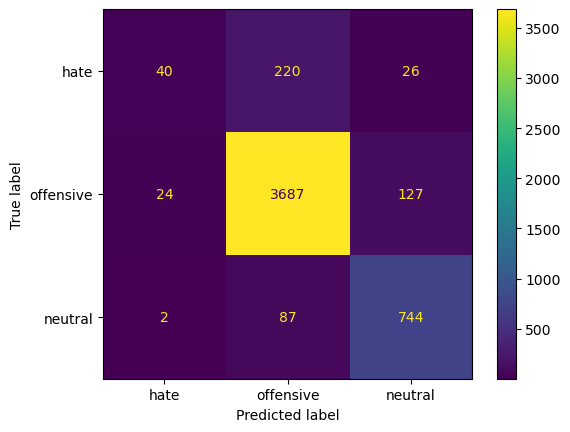

In [46]:
cm = confusion_matrix(y_test_real, y_pred)
labels = ['hate', 'offensive', 'neutral']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot();

# 6. Conclusions

It's worth noting that, despite having an accuracy of 90%, hate comments are mostly confused with offensive comments. This is due to the similarity in vocabulary used between them and a higher number of offensive comments compared to hate comments, creating a narrow separation between both domains. Consequently, the model tends to easily confuse them.

On the other hand, it is observed that the model distinguishes with an acceptable precision between hate/offensive comments and neutral ones, being able to identify the former and make decisions accordingly.

Finally, it should be emphasized that this model requires improvement, as it is necessary to increase accuracy in identifying hate comments, given their significance in the detection process.